In [24]:
import subprocess
import numpy as np

In [78]:
# Easy access/variable params
intro_time = 264 #22 years (2022 intro, sort of)
sim_duration = 864 #72 years

# needed for other things, but not tuneable params
n_inits = 100
n_assem_core = 3
assem_size = 29565
init_total_assem_size = n_inits * n_assem_core * assem_size

# Protoype Definitions:
1. LWR
2. Fuel Cycle Facilities

## 1. LWR

In [79]:
lwr = {'name' : 'LWR',
       'lifetime' : 720,
       'config' : {'Reactor' : {'fuel_incommods' :  {'val' : ['UOX_Additive', 'UOX_NoAdditive']},
                                'fuel_outcommods' : {'val' : ['SpentUOX_Additive', 'SpentUOX_NoAdditive']},
                                'fuel_inrecipes' :  {'val' : ['UOX_232', 'UOX_no232']},
                                'fuel_outrecipes' : {'val' : ['SpentUOX_232', 'SpentUOX_no232']},
                                'fuel_prefs' : {'val' : [1, 2]},
                                'pref_change_times' : {'val' : intro_time},
                                'pref_change_commods' : {'val' : 'UOX_Additive'},
                                'pref_change_values' : {'val' : 3},
                                'cycle_time' : 18,
                                'refuel_time' : 0,
                                'assem_size' : assem_size,
                                'n_assem_core' : n_assem_core,
                                'n_assem_batch' : 1,
                                'power_cap' : 1000
                               }
                  }
      }

## 2. Fuel Cycle Facilities

In [80]:
# sources/enrichment
init_uox_source = {'name' : 'SourceInitUOX', 
                   'config' : {'Source' : {'outcommod' : 'UOX_NoAdditive',
                                           'outrecipe' : 'UOX_no232',
                                           'inventory_size' : init_total_assem_size
                                          }
                              }
                  }
natu_source = {'name' : 'SourceNatU',
               'config' : {'Source' : {'outcommod' : 'NatU',
                                       'outrecipe' : 'NU',
                                       'throughput' : 2.1e11
                                      }
                          }
              }
non_source = {'name' : 'SourceNoAdditiveIsos',
              'config' : {'Source' : {'outcommod' : 'NoAdditiveIsos',
                                      'outrecipe' : 'NoAdditive_234',
                                      'throughput' : 1e6
                                     }
                         }
             }
add_source = {'name' : 'SourceAdditiveIsos',
              'config' : {'Source' : {'outcommod' : 'AdditiveIsos',
                                      'outrecipe' : 'Additive_232_233_234',
                                      'throughput' : 1e6
                                     }
                         }
             }
enrich = {'name' : 'Enrichment', 
          'config' : {'Enrichment' : {'feed_commod' : 'NatU',
                                      'feed_recipe' : 'NU',
                                      'product_commod' : 'AlmostUOX',
                                      'tails_commod' : 'DepU',
                                      'tails_assay' : 0.0025,
                                      'swu_capacity' : 1e100,
                                      'initial_feed' : 1e100
                                     }
                     }
         }

In [89]:
# mixer/storage scheme for 2 commod streams

# Since we are using recipe-based enrichment & the enr facility can't handle
# more than two isotopes: Making 2 post-enrichment storage-then-mixer facilities
# that will take in AlmostUOX and various other isotopes to produce the UOX
# recipes. (Storage is needed to request specific recipes)

# Non Additive Fuel Material Stream
store_no232 = {'name' : 'StorageNoAdditive', 
               'config' : {'Storage' : {'in_commods' : {'val' : 'AlmostUOX'}, 
                                        'in_recipe' : 'AlmostUOX_no232', 
                                        'out_commods' : {'val' : 'AlmostUOX_NoAdditive'}, 
                                        'residence_time' : 0,
                                        'throughput' : 1e8,
                                        'max_inv_size' : 1e10
                                       }
                          }
              }
######### item may need to be wrapped in a list ###########
mix_no_stream1 = {'info' : {'mixing_ratio' : 0.0004631049477, 
                            'buf_size' : 1e6
                           },
                  'commodities' : {'item' : {'commodity' : 'NoAdditiveIsos', 
                                             'pref' : 1.0
                                            }
                                  }
                 }
mix_no_stream2 = {'info' : {'mixing_ratio' : 0.9995368950523,
                            'buf_size' : 1e8
                           },
                  'commodities' : {'item' : {'commodity' : 'AlmostUOX_NoAdditive',
                                             'pref' : 1.0
                                            }
                                  }
                 }
mix_no232 = {'name' : 'MixerNoAdditive',
             'config' : {'Mixer' : {'in_streams' : {'stream' : [mix_no_stream1, mix_no_stream2]},
                                    'out_commod' : 'UOX_NoAdditive',
                                    'throughput' : 1e10,
                                    'out_buf_size' : 1e20
                                   }
                        }
            }

# Additive Fuel Material Stream
store_232 = {'name' : 'StorageAdditive', 
             'config' : {'Storage' : {'in_commods' : {'val' : 'AlmostUOX'}, 
                                      'in_recipe' : 'AlmostUOX_232', 
                                      'out_commods' : {'val' : 'AlmostUOX_Additive'}, 
                                      'residence_time' : 0,
                                      'throughput' : 1e8,
                                      'max_inv_size' : 1e10
                                     }
                        }
            }
mix_add_stream1 = {'info' : {'mixing_ratio' : 0.0004631072127, 
                             'buf_size' : 1e6
                            },
                   'commodities' : {'item' : {'commodity' : 'AdditiveIsos', 
                                              'pref' : 1.0
                                             }
                                   }
                  }
mix_add_stream2 = {'info' : {'mixing_ratio' : 0.9995368927873,
                             'buf_size' : 1e8
                            },
                   'commodities' : {'item' : {'commodity' : 'AlmostUOX_Additive',
                                              'pref' : 1.0
                                             }
                                   }
                  }
mix_232 = {'name' : 'MixerAdditive',
           'config' : {'Mixer' : {'in_streams' : {'stream' : [mix_add_stream1, mix_add_stream2]},
                                  'out_commod' : 'UOX_Additive',
                                  'throughput' : 1e10,
                                  'out_buf_size' : 1e20
                                 }
                      }
          }

In [82]:
# storage/waste
du_store = {'name' : 'StorageDepU', 
            'config' : {'Storage' : {'in_commods' : {'val' : 'DepU'}, 
                                     'in_recipe' : 'DU', 
                                     'out_commods' : {'val' : 'StoredDepU'}, 
                                     'residence_time' : 0
                                    }
                       }
           }
lwr_cool = {'name' : 'CoolingLWR', 
            'config' : {'Storage' : {'in_commods' : {'val' : ['SpentUOX_Additive', 'SpentUOX_NoAdditive']}, 
                                     'out_commods' : {'val' : 'CooledSpentUOX'}, 
                                     'residence_time' : 81
                                    }
                       }
           }
lwr_store = {'name' : 'StorageLWR', 
             'config' : {'Storage' : {'in_commods' : {'val' : 'CooledSpentUOX'}, 
                                      'out_commods' : {'val' : 'StoredSpentUOX'}, 
                                      'residence_time' : 0
                                     }
                        }
            }
sink = {'name' : 'Waste', 
        'config' : {'Sink' : {'in_commods' : {'val' : ['StoredSpentUOX', 'StoredDepU']}
                             }
                   }
       }

# Regions and Institutions:
1. Deploy Inst (Init Fleet)
2. Manager Inst (Remainder of FC facilities)
3. Growth Region

## 1. Init LWR Fleet (Deploy Inst)

In [83]:
init_lwr_prototypes = ['LWR' for x in range(0, n_inits)]
n_builds = [1 for x in range(0, n_inits)]
build_times = [x + 1 for x in range(0, 17) for y in range(0,6)]
del build_times[-3:-1]
lifetimes = [181, 186, 191, 196, 
             201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296,
             301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396,
             401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496,
             501, 506, 511, 516, 521, 526, 531, 536, 541, 546, 551, 556, 561, 566, 571, 576, 581, 586, 591, 596,
             601, 606, 611, 616, 621, 626, 631, 636, 641, 646, 651, 656, 661, 666, 671, 676
            ]

assert len(init_lwr_prototypes) == n_inits
assert len(n_builds) == n_inits
assert len(build_times) == n_inits
assert len(lifetimes) == n_inits

In [84]:
init_fleet = {'name' : 'InitFleet', 
              'config' : {'DeployInst' : {'prototypes' :  {'val' : init_lwr_prototypes},
                                          'n_build' :     {'val' : n_builds},
                                          'build_times' : {'val' : build_times},
                                          'lifetimes' :   {'val' : lifetimes}
                                         }
                         }
             }

## 2. FC Inst (Manager Inst)

In [90]:
fc_prototypes = ['SourceNatU', 'SourceNoAdditiveIsos', 'SourceAdditiveIsos', 'Enrichment', 'StorageDepU', 
                 'StorageNoAdditive', 'MixerNoAdditive', 'StorageAdditive', 'MixerAdditive', 
                 'LWR', 'CoolingLWR', 'StorageLWR', 'Waste'
                ]

fc_inst = {'name' : 'FCInst', 
           'initialfacilitylist' : {'entry' : [{'number' : 1, 'prototype' : 'SourceInitUOX'},
                                               {'number' : 1, 'prototype' : 'SourceNatU'},
                                               {'number' : 1, 'prototype' : 'SourceNoAdditiveIsos'},
                                               {'number' : 1, 'prototype' : 'SourceAdditiveIsos'},
                                               {'number' : 1, 'prototype' : 'Enrichment'},
                                               {'number' : 1, 'prototype' : 'StorageDepU'},
                                               {'number' : 1, 'prototype' : 'StorageNoAdditive'},
                                               {'number' : 1, 'prototype' : 'MixerNoAdditive'},
                                               {'number' : 1, 'prototype' : 'StorageAdditive'},
                                               {'number' : 1, 'prototype' : 'MixerAdditive'},
                                               {'number' : 1, 'prototype' : 'CoolingLWR'},
                                               {'number' : 1, 'prototype' : 'StorageLWR'},
                                               {'number' : 1, 'prototype' : 'Waste'}]
                                   },
           'config' : {'ManagerInst' : {'prototypes' : {'val' : fc_prototypes}
                                       }
                      }
          }

## 3. Growth Region

In [91]:
lin_func = {'piece' : [{'start' : 18,
                        'function' : {'type' : 'linear',
                                      'params' : '0 100000'
                                     }
                       }]
           }

growth_region = {'GrowthRegion' : {'growth' : {'item' : [{'commod' : 'power',
                                                          'piecewise_function' : lin_func
                                                         }]
                                              }
                                  }
                }

# Recipes
1. Depleted U
2. Natural U
3. NonAdditive U Isotopes (U234)
4. Additive U Isotopes (U232, U233, U234)
5. Almost UOX NonAdditive Enr Ratio
6. Almost UOX Additive Enr Ratio
7. UOX without Additive
8. UOX with Additive
9. Spent UOX from #7
10. Spent UOX from #8

In [87]:
#1
dep_u = {'name' : 'DU',
         'basis' : 'mass',
         'nuclide' : [{'id' : 'U235', 'comp' : 0.0025}, 
                      {'id' : 'U238', 'comp' : 0.9975}]
        }
#2
nat_u = {'name' : 'NU',
         'basis' : 'mass',
         'nuclide' : [{'id' : 'U235', 'comp' : 0.007110}, 
                      {'id' : 'U238', 'comp' : 0.992890}]
        }
#3
isos_no232 = {'name' : 'NoAdditive_234',
             'basis' : 'mass',
             'nuclide' : [{'id' : 'U234', 'comp' : 1.0},]
            }
#4
isos_232 = {'name' : 'Additive_232_233_234',
            'basis' : 'mass',
            'nuclide' : [{'id' : 'U232', 'comp' : 0.0000000010434},
                         {'id' : 'U233', 'comp' : 0.0000000012228},
                         {'id' : 'U234', 'comp' : 0.0004631049466}]
           }
#5
enr_no232 = {'name' : 'AlmostUOX_no232',
             'basis' : 'mass',
             'nuclide' : [{'id' : 'U235', 'comp' : 0.0499062302930}, 
                          {'id' : 'U238', 'comp' : 0.9496306647594}]
            }
#6
enr_232 = {'name' : 'AlmostUOX_232',
           'basis' : 'mass',
           'nuclide' : [{'id' : 'U235', 'comp' : 0.0499062301796},
                        {'id' : 'U238', 'comp' : 0.9496306626077}]
          }
#7
uox_no232 = {'name' : 'UOX_no232',
             'basis' : 'mass',
             'nuclide' : [{'id' : 'U234', 'comp' : 0.0004631049477},
                          {'id' : 'U235', 'comp' : 0.0499062302930}, 
                          {'id' : 'U238', 'comp' : 0.9496306647594}]
            }
#8
uox_232 = {'name' : 'UOX_232',
           'basis' : 'mass',
           'nuclide' : [{'id' : 'U232', 'comp' : 0.0000000010434},
                        {'id' : 'U233', 'comp' : 0.0000000012228},
                        {'id' : 'U234', 'comp' : 0.0004631049466}, 
                        {'id' : 'U235', 'comp' : 0.0499062301796},
                        {'id' : 'U238', 'comp' : 0.9496306626077}]
          }
#9
# All non-U values are fake, and U238 is reduced from 
# 0.9760572827708 to accomodate these fake values
spent_no232 = {'name' : 'SpentUOX_no232',
               'basis' : 'mass',
               'nuclide' : [{'id' : 'U232',  'comp' : 0.0000000002838},
                            {'id' : 'U233',  'comp' : 0.0000000058245},
                            {'id' : 'U234',  'comp' : 0.0002961396326}, 
                            {'id' : 'U235',  'comp' : 0.0174611824759},
                            {'id' : 'U236',  'comp' : 0.0061853889980},
                            {'id' : 'U238',  'comp' : 0.9250572827708},
                            {'id' : 'Pu239', 'comp' : 0.0100000000000},
                            {'id' : 'Am241', 'comp' : 0.0010000000000},
                            {'id' : 'Cs137', 'comp' : 0.0400000000000}]
              }
#10
# All non-U values are fake, and U238 is reduced from 
# 0.9760334572009 to accomodate these fake values
spent_232 = {'name' : 'SpentUOX_232',
             'basis' : 'mass',
             'nuclide' : [{'id' : 'U232',  'comp' : 0.0000000009065},
                          {'id' : 'U233',  'comp' : 0.0000000062943},
                          {'id' : 'U234',  'comp' : 0.0002327879338}, 
                          {'id' : 'U235',  'comp' : 0.0175266370423},
                          {'id' : 'U236',  'comp' : 0.0062071106222},
                          {'id' : 'U238',  'comp' : 0.9250334572009},
                          {'id' : 'Pu239', 'comp' : 0.0100000000000},
                          {'id' : 'Am241', 'comp' : 0.0010000000000},
                          {'id' : 'Cs137', 'comp' : 0.0400000000000}]
            }

# Main Input File

In [92]:
control = {'duration' : sim_duration, 
           'startmonth' : 1, 
           'startyear' : 2000,
           'dt' : 86400
          }

archetypes = {'spec' : [{'lib' : 'cycamore', 'name' : 'Source'},
                        {'lib' : 'cycamore', 'name' : 'Enrichment'},
                        {'lib' : 'cycamore', 'name' : 'Mixer'},
                        {'lib' : 'cycamore', 'name' : 'Reactor'},
                        {'lib' : 'cycamore', 'name' : 'Storage'},
                        {'lib' : 'cycamore', 'name' : 'Sink'},
                        {'lib' : 'cycamore', 'name' : 'DeployInst'},
                        {'lib' : 'cycamore', 'name' : 'ManagerInst'},
                        {'lib' : 'cycamore', 'name' : 'GrowthRegion'},
                      ]
             }

region = {'name' : 'GrowthRegion', 
          'config' : growth_region, 
          'institution' : [init_fleet, fc_inst]
         }

test_sim = {'simulation' : {'control' : control,
                            'archetypes' : archetypes,
                            'region' : region,
                            'facility' : [init_uox_source, natu_source, non_source, add_source, enrich,
                                          du_store, store_no232, mix_no232, store_232, mix_232,
                                          lwr, lwr_cool, lwr_store, sink],
                            'recipe' : [dep_u, nat_u, isos_no232, isos_232, 
                                        enr_no232, enr_232, uox_no232, uox_232,
                                        spent_no232, spent_232
                                       ]
                           }
           }

In [93]:
with open('test_py.py', 'w') as outfile: 
    outfile.write('SIMULATION = ' + str(test_sim))
subprocess.run(['rm', 'test_py.sqlite'])
subprocess.run(['cyclus', 'test_py.py', '-o', 'test_py.sqlite'])
#, stdout=subprocess.PIPE)
#subprocess.run(['cyclus', 'test_py.py', '-o', 'test_py.sqlite'], capture_output=True).stdout

CompletedProcess(args=['cyclus', 'test_py.py', '-o', 'test_py.sqlite'], returncode=0)

In [37]:
import cymetric as cym
from cymetric import graphs as cgr

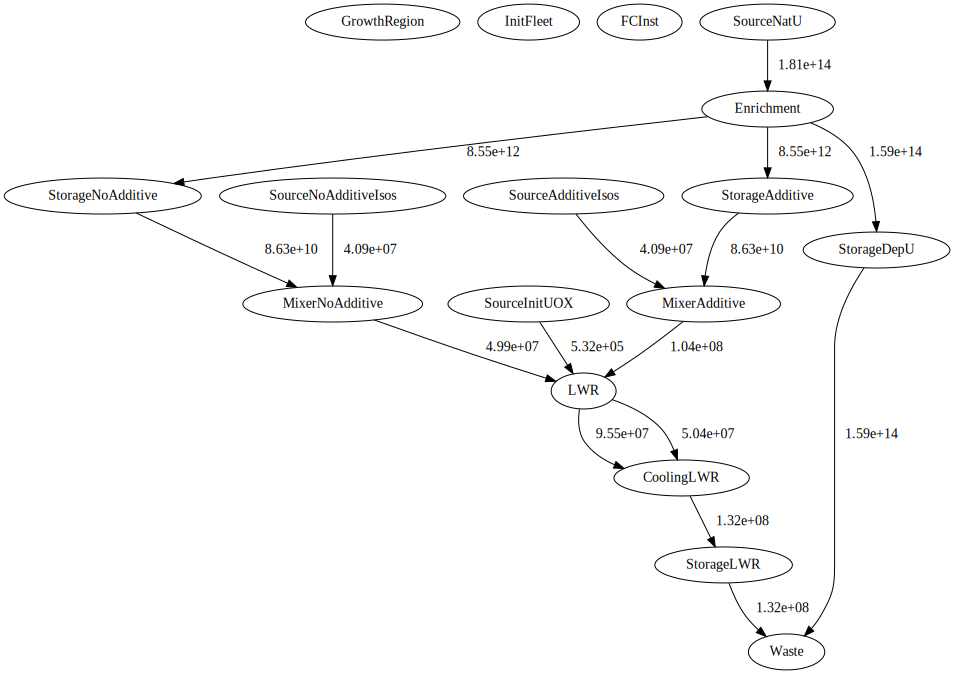

In [94]:
db = cym.dbopen('./test_py.sqlite')
ev = cym.Evaluator(db=db, write=False)
cgr.flow_graph(ev, label='mass')